Name : Jay Senjaliya<br>
Enrollment : 202511068

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

np.random.seed(42)

## Dataset Generation - Cigar Dataset

In [2]:
def generate_cigar_data(n_samples=1000):
    """Generate the Cigar dataset - an elongated ellipse rotated 30 degrees"""
    np.random.seed(42)
    X = np.random.randn(n_samples, 2)
    X[:, 0] *= 100.0
    X[:, 1] *= 0.01
    
    theta = np.radians(30)
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    X = X @ R
    
    true_w = np.array([1.5, -2.0])
    y = X @ true_w + np.random.normal(0, 1, n_samples)
    
    return X, y, true_w

In [3]:

X, y, true_w = generate_cigar_data(n_samples=1000)
y_binary = (y > np.median(y)).astype(float)  # For Focal Loss

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"True weights: {true_w}")
print(f"Binary labels: {np.sum(y_binary)}/{len(y_binary)} positive")

X shape: (1000, 2)
y shape: (1000,)
True weights: [ 1.5 -2. ]
Binary labels: 500.0/1000 positive


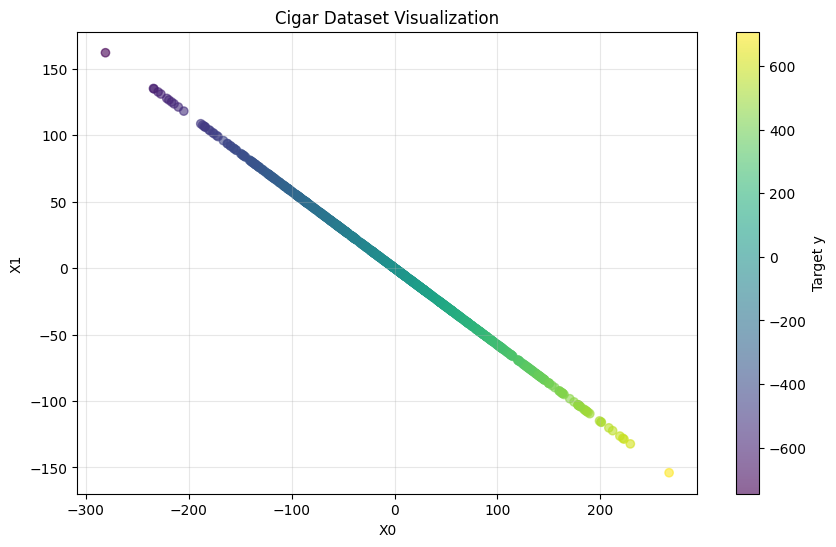

In [4]:
# Visualize dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(label='Target y')
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Cigar Dataset Visualization')
plt.grid(True, alpha=0.3)
plt.savefig('cigar_dataset.png', dpi=150)
plt.show()

## Loss Functions and Gradients

In [5]:

def mse_loss(w, X, y):
    n = len(y)
    pred = X @ w
    return (1/n) * np.sum((pred - y)**2)

def mse_gradient(w, X, y):
    n = len(y)
    pred = X @ w
    return (2/n) * (X.T @ (pred - y))

In [6]:

def logcosh_loss(w, X, y):
    pred = X @ w
    residuals = pred - y
    return (1/len(y)) * (np.sum(np.log(np.cosh(np.clip(residuals, -500, 500)))))

def logcosh_gradient(w, X, y):
    pred = X @ w
    residuals = pred - y
    return (1/len(y)) * (X.T @ np.tanh(residuals))

In [7]:

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def focal_loss(w, X, y, gamma=2.0):
    z = X @ w
    p = sigmoid(z)
    p = np.clip(p, 1e-7, 1 - 1e-7)
    
    loss = -np.sum(y * (1 - p)**gamma * np.log(p) +
                   (1 - y) * p**gamma * np.log(1 - p))
    return loss

def focal_gradient(w, X, y, gamma=2.0):
    z = X @ w
    p = sigmoid(z)
    
    if gamma == 0:
        errors = p - y
        gradient = X.T @ errors 
    else:
        p_clipped = np.clip(p, 1e-15, 1 - 1e-15)
        
        term1 = y * (
            gamma * (1 - p_clipped)**gamma * np.log(p_clipped) 
            - (1 - p_clipped)**(gamma + 1)
        )
        
        term2 = (1 - y) * (
            -gamma * p_clipped**gamma * np.log(1 - p_clipped) 
            + p_clipped**(gamma + 1)
        )
        
        errors = term1 + term2
        gradient = X.T @ errors  
    
    return gradient

##  Gradient Descent Optimizers

In [8]:
class GradientDescentOptimizer:
    
    def __init__(self, learning_rate=0.0001, max_iters=500, batch_size=32):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.batch_size = batch_size
        
        # History storage
        self.loss_history = []
        self.weight_history = []
        self.time_history = []
        self.final_weights = None
    
    def fit_bgd(self, X, y, loss_fn, grad_fn):
        
        n_features = X.shape[1]
        w = np.zeros(n_features)
        
        self.loss_history = []
        self.weight_history = [w.copy()]
        self.time_history = [0]
        
        start_time = time.time()
        
        for i in range(self.max_iters):
            loss = loss_fn(w, X, y)
            self.loss_history.append(loss)
            
            grad = grad_fn(w, X, y)
            w = w - self.learning_rate * grad
            
            self.weight_history.append(w.copy())
            self.time_history.append(time.time() - start_time)
        
        self.final_weights = w
        return w
    
    def fit_sgd(self, X, y, loss_fn, grad_fn):
        
        n_samples, n_features = X.shape
        w = np.zeros(n_features)
        
        self.loss_history = []
        self.weight_history = [w.copy()]
        self.time_history = [0]
        
        start_time = time.time()
        
        for i in range(self.max_iters):
           
            loss = loss_fn(w, X, y)
            self.loss_history.append(loss)
            
        
            idx = np.random.randint(0, n_samples)
            X_sample = X[idx:idx+1]
            y_sample = y[idx:idx+1]
            
            grad = grad_fn(w, X_sample, y_sample)
            w = w - self.learning_rate * grad
            
            self.weight_history.append(w.copy())
            self.time_history.append(time.time() - start_time)
        
        self.final_weights = w
        return w
    
    def fit_minibatch(self, X, y, loss_fn, grad_fn):
        
        n_samples, n_features = X.shape
        w = np.zeros(n_features)
        
        self.loss_history = []
        self.weight_history = [w.copy()]
        self.time_history = [0]
        
        start_time = time.time()
        
        for i in range(self.max_iters):
            
            loss = loss_fn(w, X, y)
            self.loss_history.append(loss)
            
            
            indices = np.random.choice(n_samples, self.batch_size, replace=False)
            X_batch = X[indices]
            y_batch = y[indices]
            
            grad = grad_fn(w, X_batch, y_batch)
            w = w - self.learning_rate * grad
            
            self.weight_history.append(w.copy())
            self.time_history.append(time.time() - start_time)
        
        self.final_weights = w
        return w

## Visualization Functions

In [9]:
def plot_convergence(results, title, save_path=None):
    
    plt.figure(figsize=(10, 6))
    
    for name, data in results.items():
        plt.semilogy(data['loss'], label=name, linewidth=1.5)
    
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.title(f'Convergence Plot - {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # if save_path:
    #     plt.savefig(save_path, dpi=150)
    plt.show()

In [10]:
def plot_trajectory(results, loss_fn, X, y, title, save_path=None, w_range=(-5, 5)):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    
    w0_vals = np.linspace(w_range[0], w_range[1], 100)
    w1_vals = np.linspace(w_range[0], w_range[1], 100)
    W0, W1 = np.meshgrid(w0_vals, w1_vals)
    
    
    Z = np.zeros_like(W0)
    for i in range(W0.shape[0]):
        for j in range(W0.shape[1]):
            w = np.array([W0[i, j], W1[i, j]])
            Z[i, j] = loss_fn(w, X, y)
    
    Z_log = np.log(Z + 1)
    
    
    contour = ax.contour(W0, W1, Z_log, levels=30, cmap='viridis', alpha=0.7)
    ax.contourf(W0, W1, Z_log, levels=30, cmap='viridis', alpha=0.3)
    
    
    colors = ['red', 'blue', 'green']
    for (name, data), color in zip(results.items(), colors):
        weights = np.array(data['weights'])
        ax.plot(weights[:, 0], weights[:, 1], color=color, label=name, linewidth=1.5)
        ax.scatter(weights[0, 0], weights[0, 1], color=color, marker='o', s=100,label='Initial')
        ax.scatter(weights[-1, 0], weights[-1, 1], color=color, marker='*', s=200,label='Final')
    
    ax.set_xlabel('w0')
    ax.set_ylabel('w1')
    ax.set_title(f'Weight Trajectory - {title}')
    ax.legend()
    plt.colorbar(contour, ax=ax, label='log(Loss + 1)')
    
    # if save_path:
    #     plt.savefig(save_path, dpi=150)
    plt.show()

In [11]:
def plot_wall_clock(results, title, save_path=None):
   
    plt.figure(figsize=(10, 6))
    
    for name, data in results.items():
        plt.semilogy(data['time'][1:], data['loss'], label=name, linewidth=1.5)
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Loss (log scale)')
    plt.title(f'Wall-Clock Efficiency - {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # if save_path:
    #     plt.savefig(save_path, dpi=150)
    plt.show()

In [12]:
def plot_3d_surface(loss_fn, X, y, title, save_path=None, w_range=(-5, 5)):
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
 
    w0_vals = np.linspace(w_range[0], w_range[1], 50)
    w1_vals = np.linspace(w_range[0], w_range[1], 50)
    W0, W1 = np.meshgrid(w0_vals, w1_vals)
    
    
    Z = np.zeros_like(W0)
    for i in range(W0.shape[0]):
        for j in range(W0.shape[1]):
            w = np.array([W0[i, j], W1[i, j]])
            Z[i, j] = loss_fn(w, X, y)
    
   
    Z_log = np.log(Z + 1)
    
    
    surf = ax.plot_surface(W0, W1, Z_log, cmap='viridis', alpha=0.8, edgecolor='none')
    
    ax.set_xlabel('w0')
    ax.set_ylabel('w1')
    ax.set_zlabel('log(Loss + 1)')
    ax.set_title(f'3D Loss Surface - {title}')
    
    fig.colorbar(surf, shrink=0.5, aspect=5, label='log(Loss + 1)')
    
    # if save_path:
    #     plt.savefig(save_path, dpi=150)
    plt.show()

In [13]:
def plot_3d_loss_surface_trajectory(results, loss_fn, X, y, title, save_path=None, w_range=(-2, 5)):
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
   
    w1_vals = np.linspace(w_range[0], w_range[1], 50)
    w2_vals = np.linspace(-5, 2, 50)
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    
    
    Z = np.zeros_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            w = np.array([W1[i, j], W2[i, j]])
            Z[i, j] = loss_fn(w, X, y)
    
    
    ax.plot_surface(W1, W2, Z, cmap='viridis', alpha=0.6, edgecolor='none')
    
    
    colors = {'BGD': 'red', 'SGD': 'orange', 'Mini-Batch': 'blue'}
    labels = {'BGD': 'bgd', 'SGD': 'sgd', 'Mini-Batch': 'minibatch'}
    
    for name, data in results.items():
        weights = np.array(data['weights'])
        losses = [loss_fn(w, X, y) for w in weights]
        
        ax.plot(weights[:, 0], weights[:, 1], losses, 
                color=colors[name], label=labels[name], linewidth=2)
        
        
        if name == 'BGD':
            ax.scatter(weights[0, 0], weights[0, 1], losses[0], 
                      color='green', marker='o', s=100, label='Start')
        
        
        ax.scatter(weights[-1, 0], weights[-1, 1], losses[-1], 
                  color='red', marker='*', s=150, label='End' if name == 'BGD' else '')
    
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_zlabel('Loss')
    ax.set_title(f'3D Loss Surface & Trajectory ({title})')
    
    
    handles, labels_list = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_list, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # if save_path:
    #     plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


## 1. MSE Loss

In [14]:

lr = 1e-6
max_iters = 500
batch_size = 32

print("=" * 50)
print("MSE Loss Experiments")
print("=" * 50)


print("Running BGD...")
opt_bgd = GradientDescentOptimizer(learning_rate=0.0001, max_iters=1000)
opt_bgd.fit_bgd(X, y, mse_loss, mse_gradient)
print(f"  Final weights: {opt_bgd.final_weights}")


print("Running SGD...")
opt_sgd = GradientDescentOptimizer(learning_rate=0.00001, max_iters=max_iters)
opt_sgd.fit_sgd(X, y, mse_loss, mse_gradient)
print(f"  Final weights: {opt_sgd.final_weights}")

print("Running Mini-Batch...")
opt_mb = GradientDescentOptimizer(learning_rate=0.0001, max_iters=1000, batch_size=batch_size)
opt_mb.fit_minibatch(X, y, mse_loss, mse_gradient)
print(f"  Final weights: {opt_mb.final_weights}")


results_mse = {
    'BGD': {'loss': opt_bgd.loss_history, 'weights': opt_bgd.weight_history, 'time': opt_bgd.time_history},
    'SGD': {'loss': opt_sgd.loss_history, 'weights': opt_sgd.weight_history, 'time': opt_sgd.time_history},
    'Mini-Batch': {'loss': opt_mb.loss_history, 'weights': opt_mb.weight_history, 'time': opt_mb.time_history}
}

MSE Loss Experiments
Running BGD...
  Final weights: [ 1.99127574 -1.14964432]
Running SGD...
  Final weights: [ 1.9951467  -1.15180295]
Running Mini-Batch...
  Final weights: [ 1.98760978 -1.14744088]


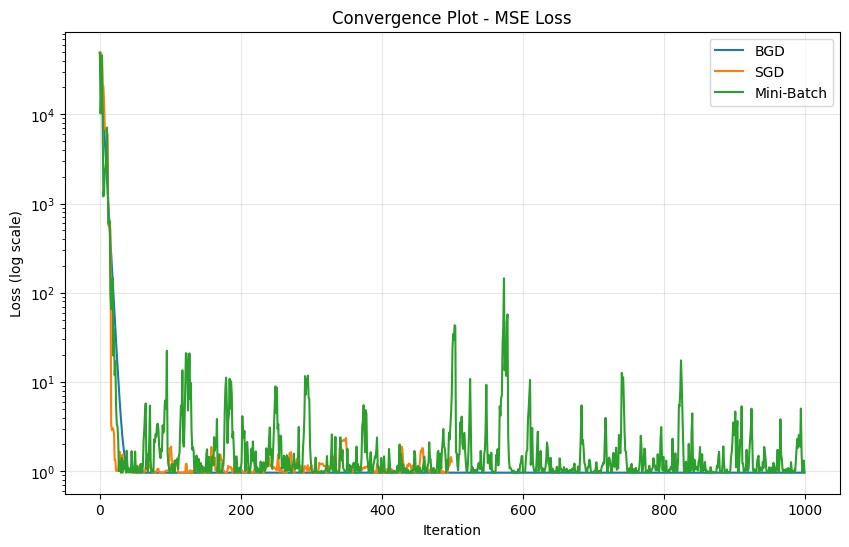

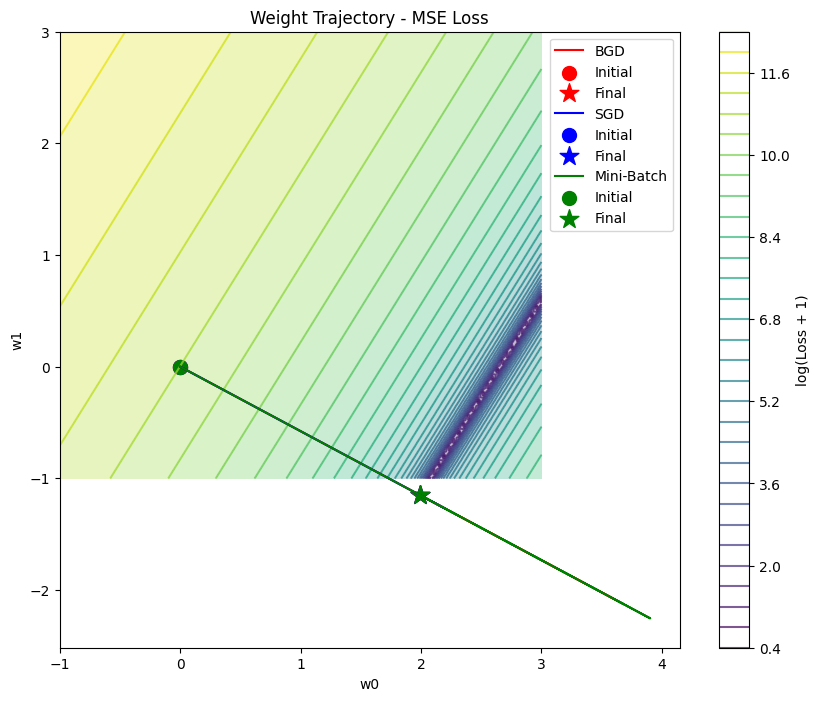

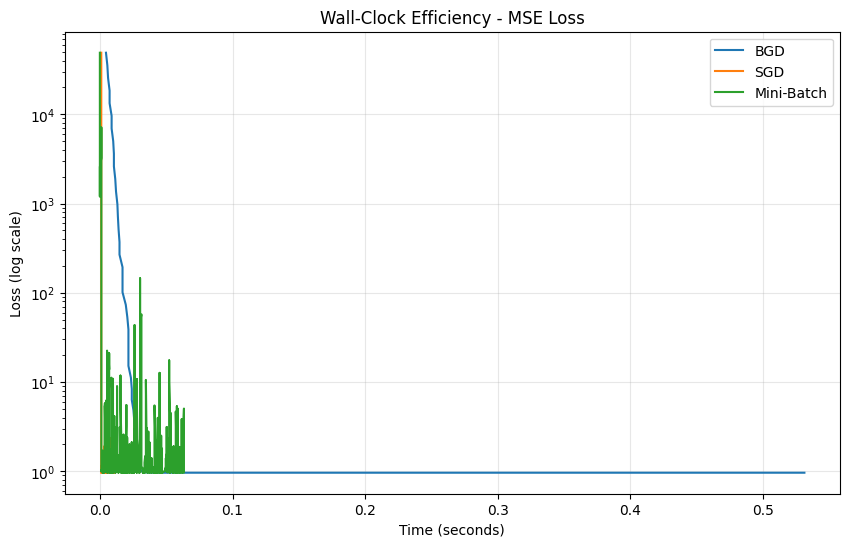

In [15]:

plot_convergence(results_mse, 'MSE Loss', 'mse_convergence.png')
plot_trajectory(results_mse, mse_loss, X, y, 'MSE Loss', 'mse_trajectory.png', w_range=(-1, 3))
plot_wall_clock(results_mse, 'MSE Loss', 'mse_wall_clock.png')

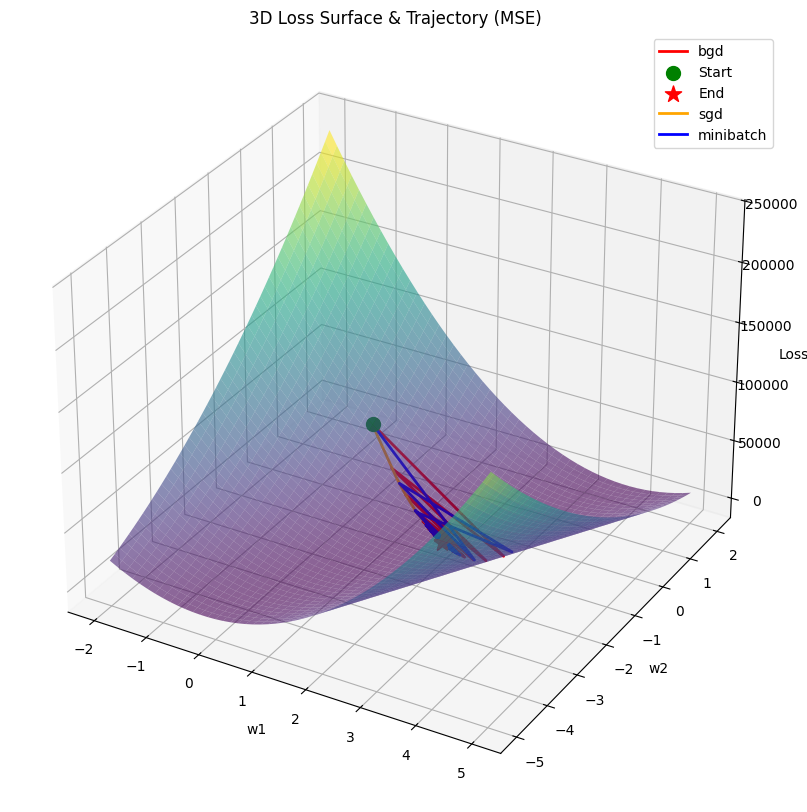

In [16]:

plot_3d_loss_surface_trajectory(results_mse, mse_loss, X, y, 'MSE', 'mse_3d_surface_trajectory.png')

## 2. Log-Cosh Loss

In [17]:
print("=" * 50)
print("Log-Cosh Loss Experiments")
print("=" * 50)

lr = 1e-6
max_iters = 500
batch_size = 64

print("Running BGD...")
opt_bgd = GradientDescentOptimizer(learning_rate=0.0001, max_iters=500)
opt_bgd.fit_bgd(X, y, logcosh_loss, logcosh_gradient)
print(f"  Final weights: {opt_bgd.final_weights}")

print("Running SGD...")
opt_sgd = GradientDescentOptimizer(learning_rate=0.0001, max_iters=1000)
opt_sgd.fit_sgd(X, y, logcosh_loss, logcosh_gradient)
print(f"  Final weights: {opt_sgd.final_weights}")


print("Running Mini-Batch...")
opt_mb = GradientDescentOptimizer(learning_rate=0.0001, max_iters=500, batch_size=batch_size)
opt_mb.fit_minibatch(X, y, logcosh_loss, logcosh_gradient)
print(f"  Final weights: {opt_mb.final_weights}")


results_logcosh = {
    'BGD': {'loss': opt_bgd.loss_history, 'weights': opt_bgd.weight_history, 'time': opt_bgd.time_history},
    'SGD': {'loss': opt_sgd.loss_history, 'weights': opt_sgd.weight_history, 'time': opt_sgd.time_history},
    'Mini-Batch': {'loss': opt_mb.loss_history, 'weights': opt_mb.weight_history, 'time': opt_mb.time_history}
}

Log-Cosh Loss Experiments
Running BGD...
  Final weights: [ 1.99122659 -1.1496336 ]
Running SGD...
  Final weights: [ 2.00315538 -1.15655821]
Running Mini-Batch...
  Final weights: [ 1.99080169 -1.1493853 ]


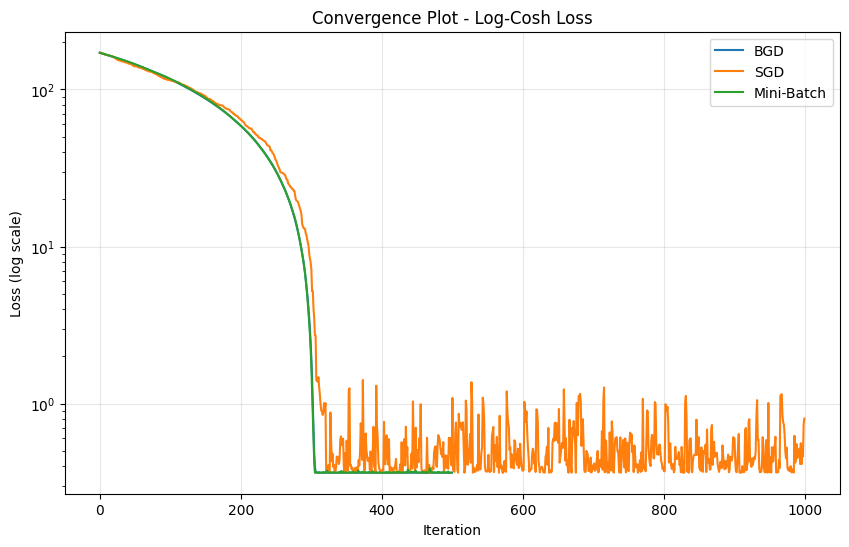

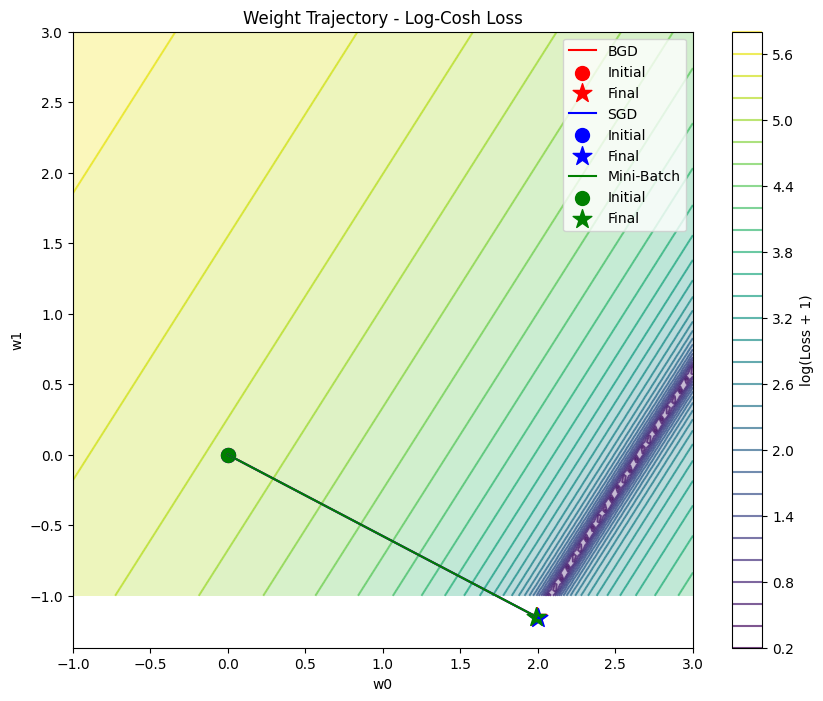

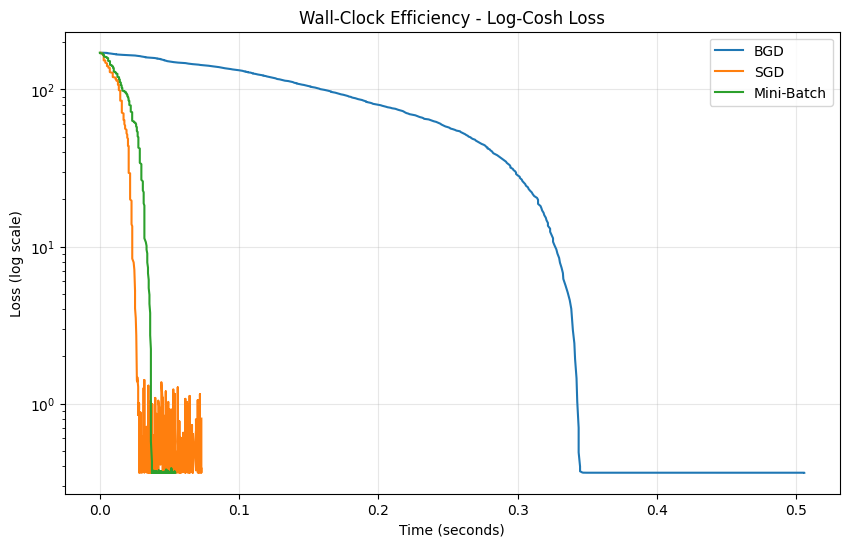

In [18]:

plot_convergence(results_logcosh, 'Log-Cosh Loss', 'logcosh_convergence.png')
plot_trajectory(results_logcosh, logcosh_loss, X, y, 'Log-Cosh Loss', 'logcosh_trajectory.png', w_range=(-1, 3))
plot_wall_clock(results_logcosh, 'Log-Cosh Loss', 'logcosh_wall_clock.png')

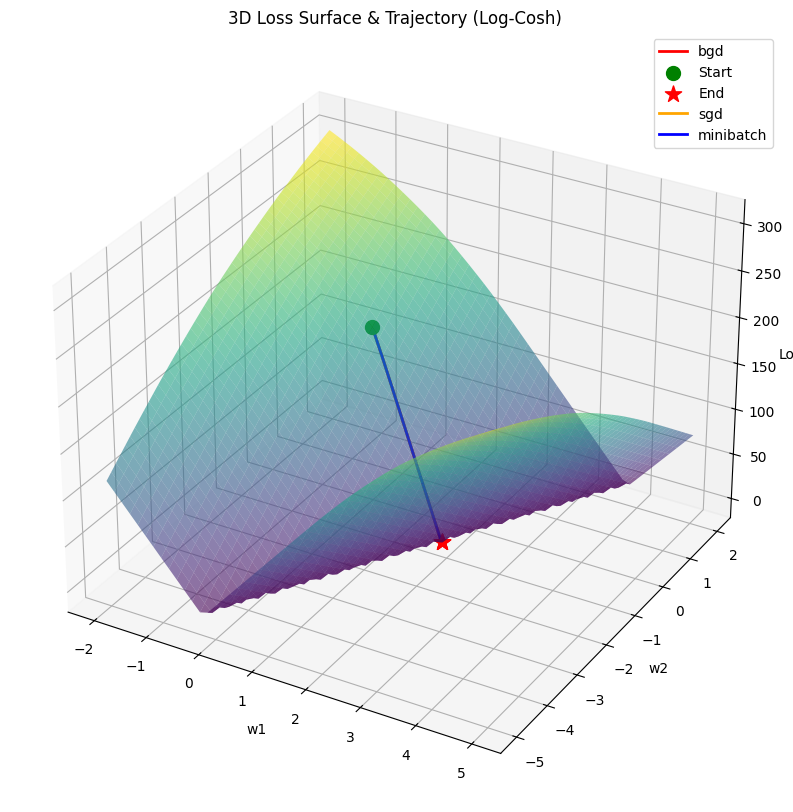

In [19]:

plot_3d_loss_surface_trajectory(results_logcosh, logcosh_loss, X, y, 'Log-Cosh', 'logcosh_3d_surface_trajectory.png')

## 3. Binary Focal Loss 

In [65]:
print("=" * 50)
print("Binary Focal Loss Experiments")
print("=" * 50)
lr = 1e-6
max_iters = 1000
batch_size = 32

def focal_loss_wrapper(w, X, y_unused):
    return focal_loss(w, X, y_binary[:len(X)])

def focal_grad_wrapper(w, X, y_unused):
    return focal_gradient(w, X, y_binary[:len(X)])


print("Running BGD...")
opt_bgd = GradientDescentOptimizer(learning_rate=0.000001, max_iters=2000)
opt_bgd.fit_bgd(X, y_binary, focal_loss_wrapper, focal_grad_wrapper)
print(f"  Final weights: {opt_bgd.final_weights}")


print("Running SGD...")
opt_sgd = GradientDescentOptimizer(learning_rate=0.000001, max_iters=1000)
opt_sgd.fit_sgd(X, y_binary, focal_loss_wrapper, focal_grad_wrapper)
print(f"  Final weights: {opt_sgd.final_weights}")


print("Running Mini-Batch...")
opt_mb = GradientDescentOptimizer(learning_rate=lr, max_iters=max_iters, batch_size=batch_size)
opt_mb.fit_minibatch(X, y_binary, focal_loss_wrapper, focal_grad_wrapper)
print(f"  Final weights: {opt_mb.final_weights}")


results_focal = {
    'BGD': {'loss': opt_bgd.loss_history, 'weights': opt_bgd.weight_history, 'time': opt_bgd.time_history},
    'SGD': {'loss': opt_sgd.loss_history, 'weights': opt_sgd.weight_history, 'time': opt_sgd.time_history},
    'Mini-Batch': {'loss': opt_mb.loss_history, 'weights': opt_mb.weight_history, 'time': opt_mb.time_history}
}

Binary Focal Loss Experiments
Running BGD...
  Final weights: [ 0.13392384 -0.07745764]
Running SGD...
  Final weights: [ 5.93310497e-05 -3.42146873e-05]
Running Mini-Batch...
  Final weights: [ 8.14115466e-05 -4.95146978e-05]


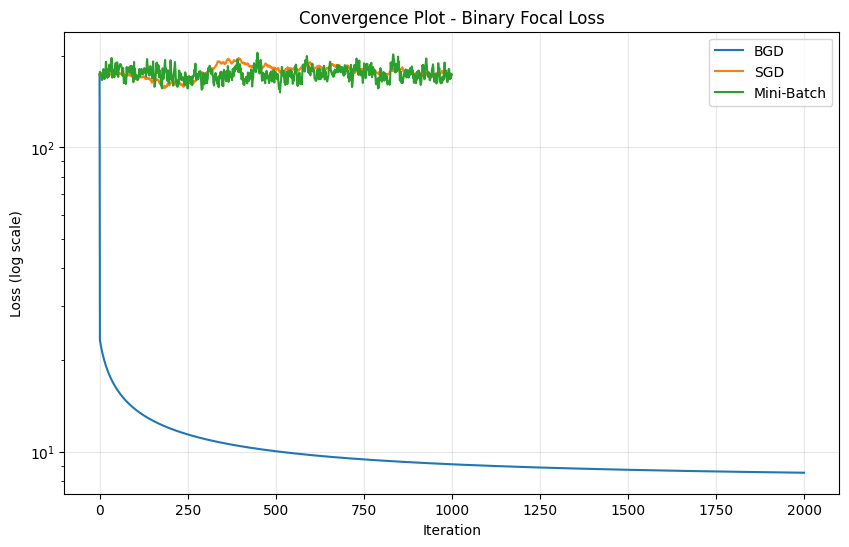

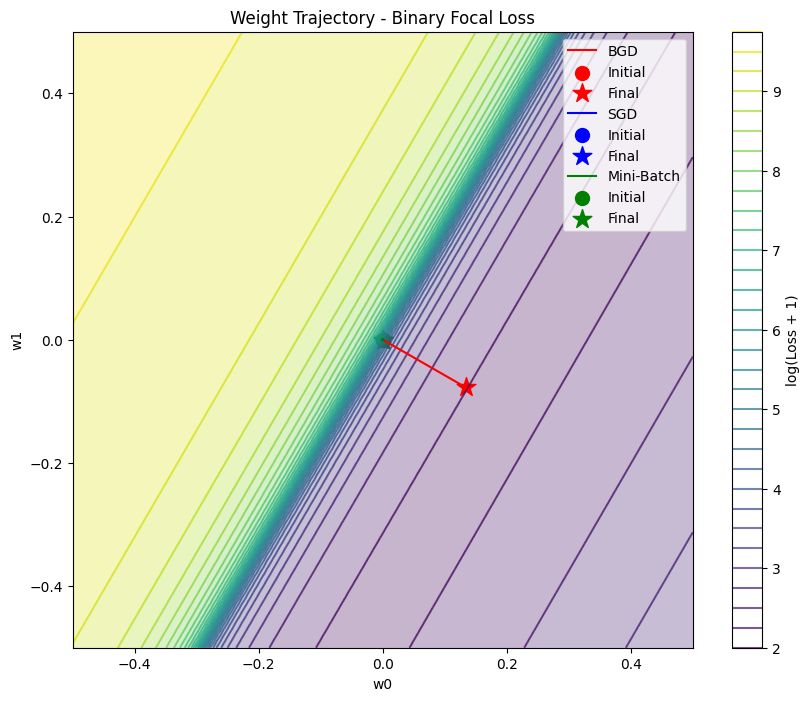

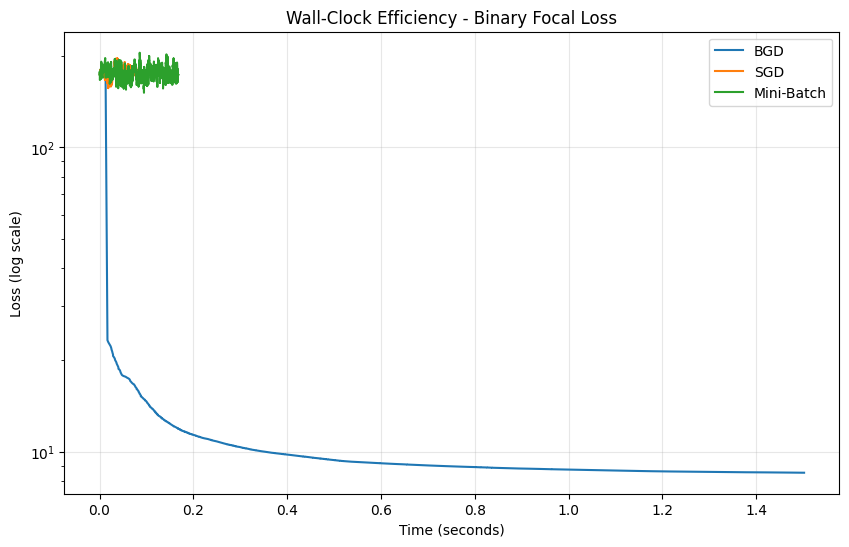

In [66]:

plot_convergence(results_focal, 'Binary Focal Loss', 'focal_convergence.png')
plot_trajectory(results_focal, focal_loss_wrapper, X, y_binary, 'Binary Focal Loss', 'focal_trajectory.png', w_range=(-0.5, 0.5))
plot_wall_clock(results_focal, 'Binary Focal Loss', 'focal_wall_clock.png')

# **Breast Cancer Wisconsin (Diagnostic) Dataset**

In [22]:


from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()
X_cancer_full = cancer.data
y_cancer = cancer.target


X_cancer = X_cancer_full[:, :2]


scaler = StandardScaler()
X_cancer = scaler.fit_transform(X_cancer)


y_cancer = y_cancer.astype(float)

print("=" * 50)
print("Breast Cancer Wisconsin Dataset Info")
print("=" * 50)
print(f"X shape: {X_cancer.shape}")
print(f"Features: mean radius, mean texture")
print(f"Class 0 (Malignant): {np.sum(y_cancer==0)} samples ({100*np.mean(y_cancer==0):.1f}%)")
print(f"Class 1 (Benign): {np.sum(y_cancer==1)} samples ({100*np.mean(y_cancer==1):.1f}%)")
print(f"Imbalance ratio: {np.sum(y_cancer==1)/np.sum(y_cancer==0):.2f}")

Breast Cancer Wisconsin Dataset Info
X shape: (569, 2)
Features: mean radius, mean texture
Class 0 (Malignant): 212 samples (37.3%)
Class 1 (Benign): 357 samples (62.7%)
Imbalance ratio: 1.68


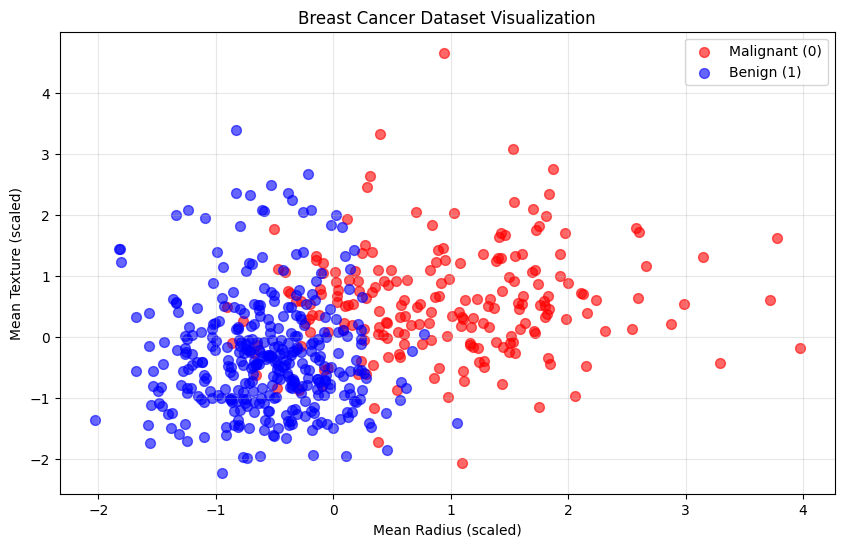

In [23]:

plt.figure(figsize=(10, 6))
plt.scatter(X_cancer[y_cancer==0, 0], X_cancer[y_cancer==0, 1], 
            c='red', label='Malignant (0)', alpha=0.6, s=50)
plt.scatter(X_cancer[y_cancer==1, 0], X_cancer[y_cancer==1, 1], 
            c='blue', label='Benign (1)', alpha=0.6, s=50)
plt.xlabel('Mean Radius (scaled)')
plt.ylabel('Mean Texture (scaled)')
plt.title('Breast Cancer Dataset Visualization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('breast_cancer_dataset.png', dpi=150)
plt.show()

In [83]:

print("=" * 50)
print("Binary Focal Loss on Breast Cancer Dataset")
print("=" * 50)


lr_cancer = 0.001
max_iters_cancer = 500


print("Running BGD...")
opt_bgd_cancer = GradientDescentOptimizer(learning_rate=0.01, max_iters=max_iters_cancer)
opt_bgd_cancer.fit_bgd(X_cancer, y_cancer, focal_loss, focal_gradient)
print(f"  Final weights: {opt_bgd_cancer.final_weights}")


print("Running SGD...")
opt_sgd_cancer = GradientDescentOptimizer(learning_rate=lr_cancer, max_iters=10000)
opt_sgd_cancer.fit_sgd(X_cancer, y_cancer, focal_loss, focal_gradient)
print(f"  Final weights: {opt_sgd_cancer.final_weights}")


print("Running Mini-Batch...")
opt_mb_cancer = GradientDescentOptimizer(learning_rate=lr_cancer, max_iters=1000, batch_size=32)
opt_mb_cancer.fit_minibatch(X_cancer, y_cancer, focal_loss, focal_gradient)
print(f"  Final weights: {opt_mb_cancer.final_weights}")


results_focal_cancer = {
    'BGD': {'loss': opt_bgd_cancer.loss_history, 'weights': opt_bgd_cancer.weight_history, 'time': opt_bgd_cancer.time_history},
    'SGD': {'loss': opt_sgd_cancer.loss_history, 'weights': opt_sgd_cancer.weight_history, 'time': opt_sgd_cancer.time_history},
    'Mini-Batch': {'loss': opt_mb_cancer.loss_history, 'weights': opt_mb_cancer.weight_history, 'time': opt_mb_cancer.time_history}
}

Binary Focal Loss on Breast Cancer Dataset
Running BGD...
  Final weights: [-1.20810964 -0.28012555]
Running SGD...
  Final weights: [-0.87162807 -0.24325909]
Running Mini-Batch...
  Final weights: [-1.1378572 -0.2683802]


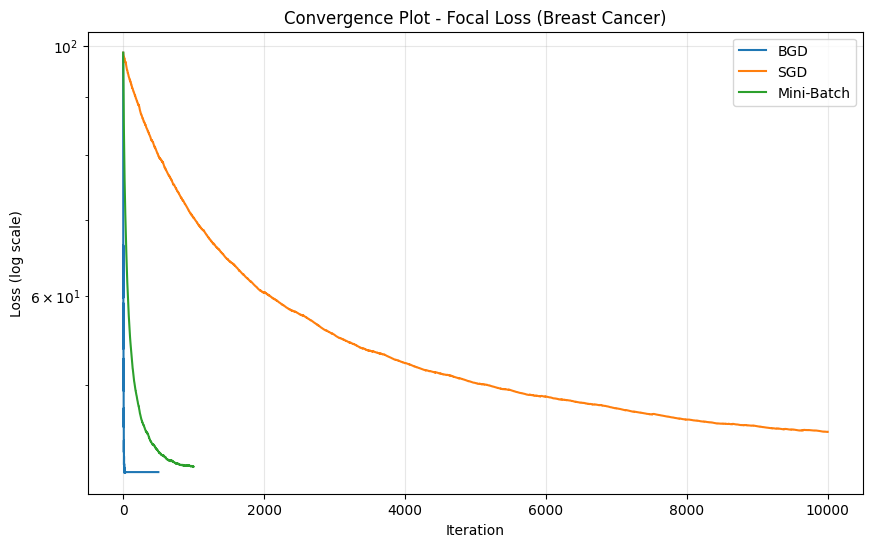

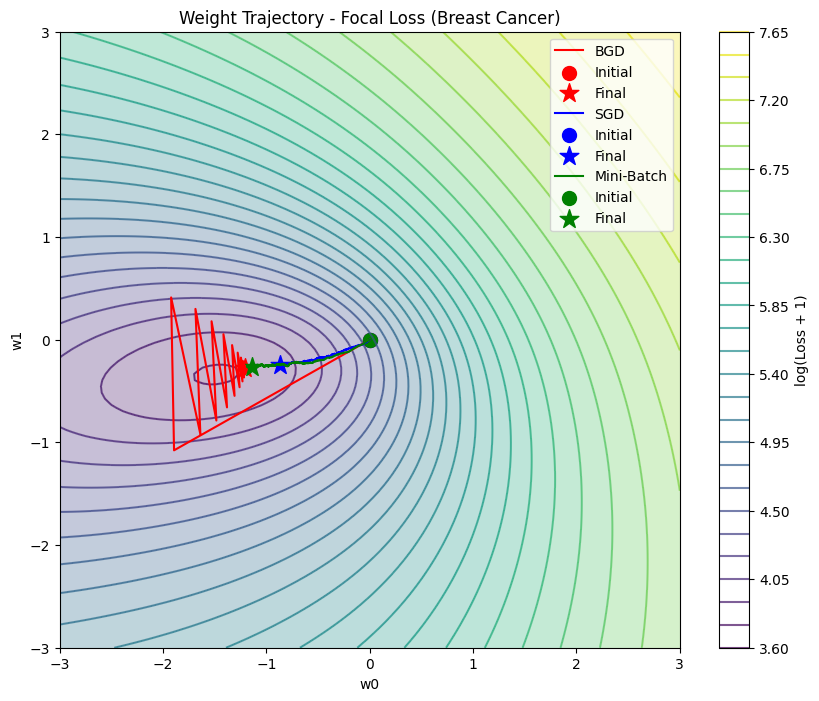

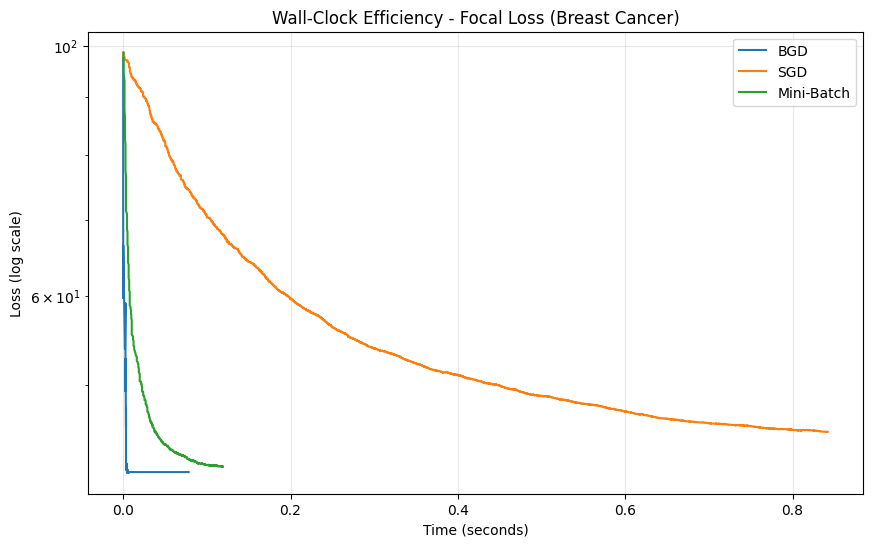

In [84]:

plot_convergence(results_focal_cancer, 'Focal Loss (Breast Cancer)', 'cancer_focal_convergence.png')
plot_trajectory(results_focal_cancer, 
                lambda w, X, y: focal_loss(w, X, y_cancer), 
                X_cancer, y_cancer, 
                'Focal Loss (Breast Cancer)', 
                'cancer_focal_trajectory.png', 
                w_range=(-3, 3))
plot_wall_clock(results_focal_cancer, 'Focal Loss (Breast Cancer)', 'cancer_focal_wall_clock.png')

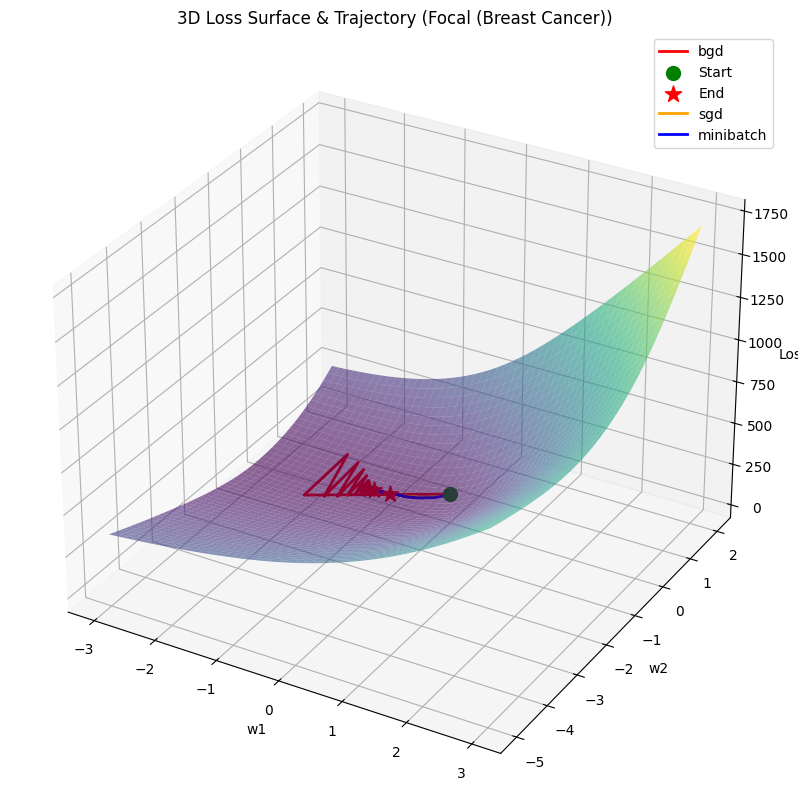

In [85]:

def focal_loss_cancer_wrapper(w, X, y):
    return focal_loss(w, X, y_cancer[:len(X)] if len(X) < len(y_cancer) else y_cancer)

plot_3d_loss_surface_trajectory(results_focal_cancer, focal_loss_cancer_wrapper, 
                                 X_cancer, y_cancer, 'Focal (Breast Cancer)', 
                                 'cancer_focal_3d.png', w_range=(-3, 3))

# **California Housing Dataset**

In [27]:


from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler


housing = fetch_california_housing()
X_housing_full = housing.data
y_housing = housing.target


X_housing = X_housing_full[:, :2]


np.random.seed(42)
indices = np.random.choice(len(X_housing), 1000, replace=False)
X_housing = X_housing[indices]
y_housing = y_housing[indices]


scaler_X = StandardScaler()
X_housing = scaler_X.fit_transform(X_housing)


y_mean, y_std = y_housing.mean(), y_housing.std()
y_housing = (y_housing - y_mean) / y_std

print("=" * 50)
print("California Housing Dataset Info")
print("=" * 50)
print(f"X shape: {X_housing.shape}")
print(f"y shape: {y_housing.shape}")
print(f"Features: MedInc (Median Income), AveRooms (Average Rooms)")
print(f"Target: Median House Value (scaled)")

California Housing Dataset Info
X shape: (1000, 2)
y shape: (1000,)
Features: MedInc (Median Income), AveRooms (Average Rooms)
Target: Median House Value (scaled)


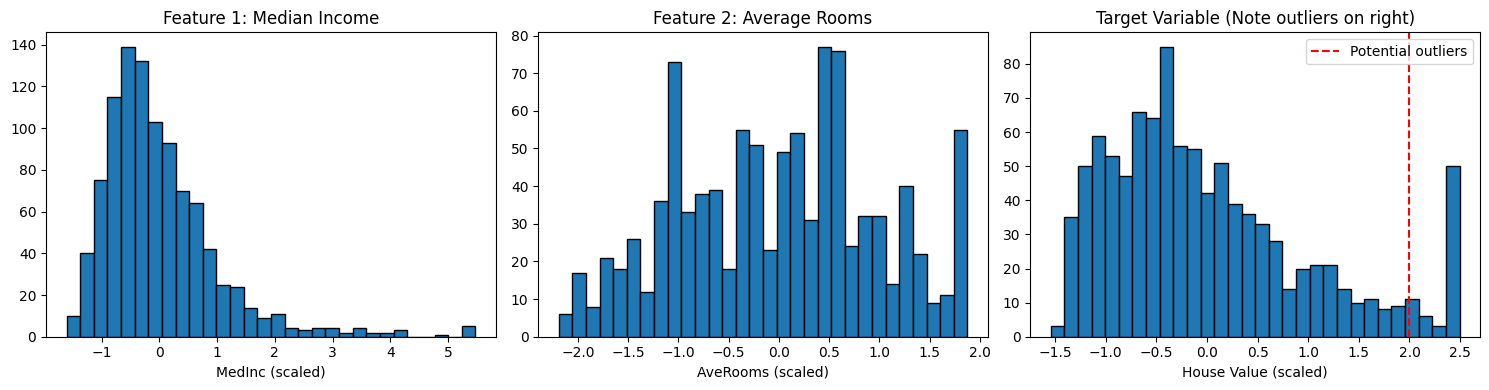


Number of potential outliers (|y| > 2 std): 63 (6.3%)


In [28]:

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


axes[0].hist(X_housing[:, 0], bins=30, edgecolor='black')
axes[0].set_xlabel('MedInc (scaled)')
axes[0].set_title('Feature 1: Median Income')

axes[1].hist(X_housing[:, 1], bins=30, edgecolor='black')
axes[1].set_xlabel('AveRooms (scaled)')
axes[1].set_title('Feature 2: Average Rooms')


axes[2].hist(y_housing, bins=30, edgecolor='black')
axes[2].axvline(x=2, color='red', linestyle='--', label='Potential outliers')
axes[2].set_xlabel('House Value (scaled)')
axes[2].set_title('Target Variable (Note outliers on right)')
axes[2].legend()

plt.tight_layout()
plt.savefig('california_housing_distributions.png', dpi=150)
plt.show()


outliers = np.sum(np.abs(y_housing) > 2)
print(f"\nNumber of potential outliers (|y| > 2 std): {outliers} ({100*outliers/len(y_housing):.1f}%)")

In [29]:

print("=" * 50)
print("MSE Loss on California Housing")
print("=" * 50)

lr_housing = 0.01
max_iters_housing = 500


print("Running BGD...")
opt_bgd_mse = GradientDescentOptimizer(learning_rate=lr_housing, max_iters=max_iters_housing)
opt_bgd_mse.fit_bgd(X_housing, y_housing, mse_loss, mse_gradient)
print(f"  Final weights: {opt_bgd_mse.final_weights}")

print("Running SGD...")
opt_sgd_mse = GradientDescentOptimizer(learning_rate=lr_housing, max_iters=max_iters_housing)
opt_sgd_mse.fit_sgd(X_housing, y_housing, mse_loss, mse_gradient)
print(f"  Final weights: {opt_sgd_mse.final_weights}")


print("Running Mini-Batch...")
opt_mb_mse = GradientDescentOptimizer(learning_rate=lr_housing, max_iters=max_iters_housing, batch_size=32)
opt_mb_mse.fit_minibatch(X_housing, y_housing, mse_loss, mse_gradient)
print(f"  Final weights: {opt_mb_mse.final_weights}")

results_mse_housing = {
    'BGD': {'loss': opt_bgd_mse.loss_history, 'weights': opt_bgd_mse.weight_history, 'time': opt_bgd_mse.time_history},
    'SGD': {'loss': opt_sgd_mse.loss_history, 'weights': opt_sgd_mse.weight_history, 'time': opt_sgd_mse.time_history},
    'Mini-Batch': {'loss': opt_mb_mse.loss_history, 'weights': opt_mb_mse.weight_history, 'time': opt_mb_mse.time_history}
}

MSE Loss on California Housing
Running BGD...
  Final weights: [0.70561634 0.16990464]
Running SGD...
  Final weights: [0.67226608 0.15635634]
Running Mini-Batch...
  Final weights: [0.71649199 0.16722854]


In [30]:

print("=" * 50)
print("Log-Cosh Loss on California Housing")
print("=" * 50)
lr_housing = 0.01

print("Running BGD...")
opt_bgd_lc = GradientDescentOptimizer(learning_rate=lr_housing, max_iters=max_iters_housing)
opt_bgd_lc.fit_bgd(X_housing, y_housing, logcosh_loss, logcosh_gradient)
print(f"  Final weights: {opt_bgd_lc.final_weights}")


print("Running SGD...")
opt_sgd_lc = GradientDescentOptimizer(learning_rate=lr_housing, max_iters=max_iters_housing)
opt_sgd_lc.fit_sgd(X_housing, y_housing, logcosh_loss, logcosh_gradient)
print(f"  Final weights: {opt_sgd_lc.final_weights}")


print("Running Mini-Batch...")
opt_mb_lc = GradientDescentOptimizer(learning_rate=lr_housing, max_iters=max_iters_housing, batch_size=32)
opt_mb_lc.fit_minibatch(X_housing, y_housing, logcosh_loss, logcosh_gradient)
print(f"  Final weights: {opt_mb_lc.final_weights}")

results_logcosh_housing = {
    'BGD': {'loss': opt_bgd_lc.loss_history, 'weights': opt_bgd_lc.weight_history, 'time': opt_bgd_lc.time_history},
    'SGD': {'loss': opt_sgd_lc.loss_history, 'weights': opt_sgd_lc.weight_history, 'time': opt_sgd_lc.time_history},
    'Mini-Batch': {'loss': opt_mb_lc.loss_history, 'weights': opt_mb_lc.weight_history, 'time': opt_mb_lc.time_history}
}

Log-Cosh Loss on California Housing
Running BGD...
  Final weights: [0.70497838 0.15313099]
Running SGD...
  Final weights: [0.75157923 0.14987508]
Running Mini-Batch...
  Final weights: [0.69872444 0.14825712]


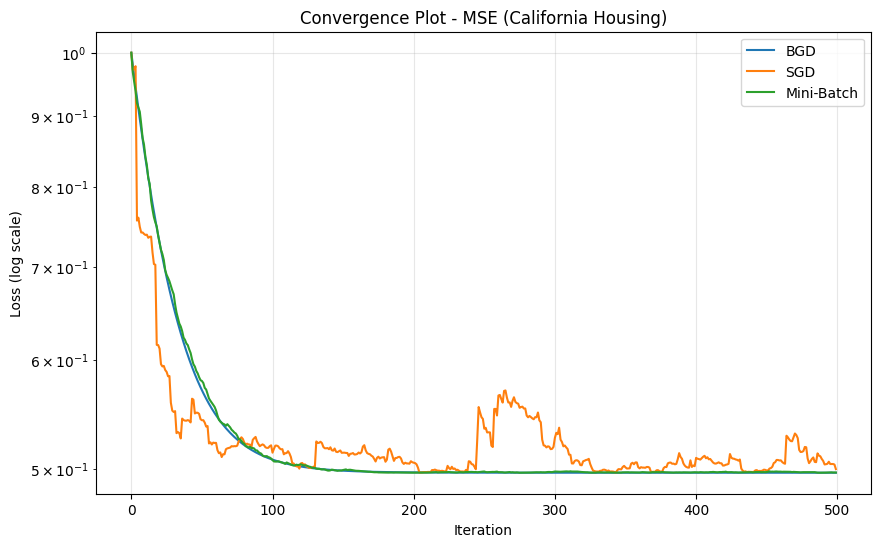

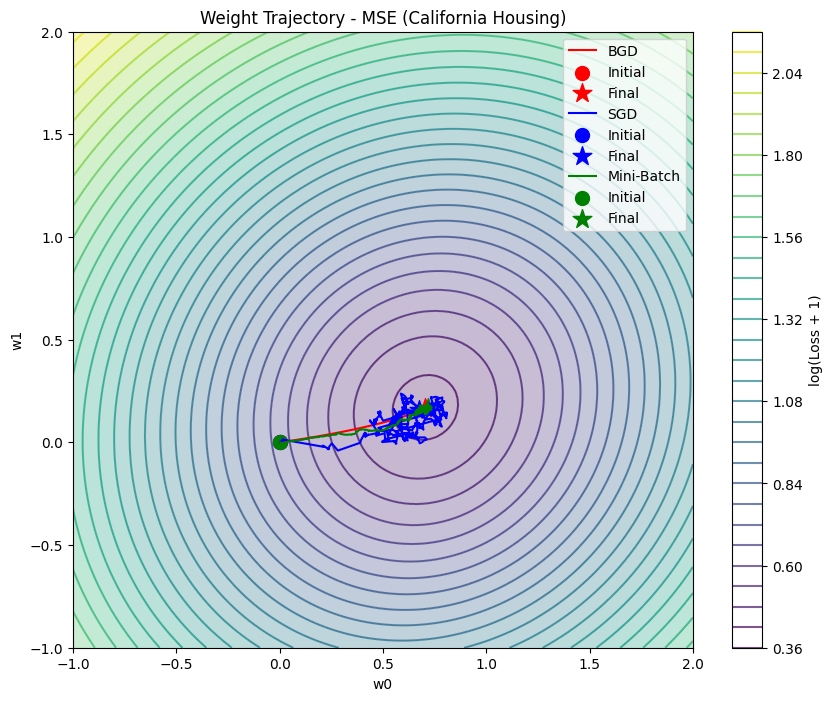

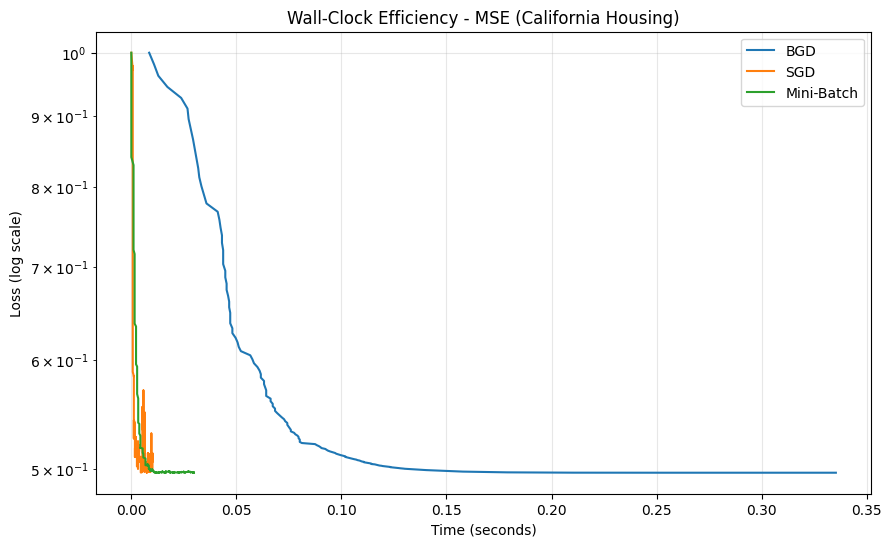

In [31]:

plot_convergence(results_mse_housing, 'MSE (California Housing)', 'housing_mse_convergence.png')
plot_trajectory(results_mse_housing, mse_loss, X_housing, y_housing, 'MSE (California Housing)', 'housing_mse_trajectory.png', w_range=(-1, 2))
plot_wall_clock(results_mse_housing, 'MSE (California Housing)', 'housing_mse_wall_clock.png')  

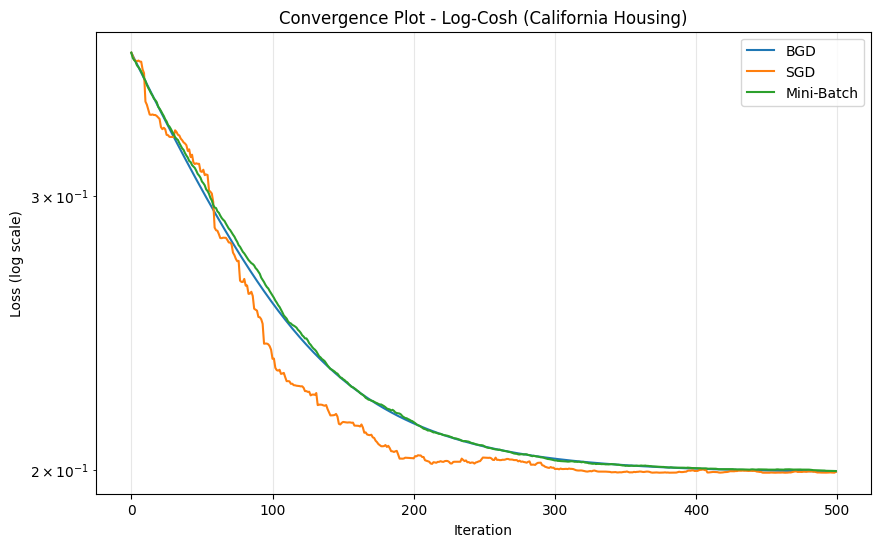

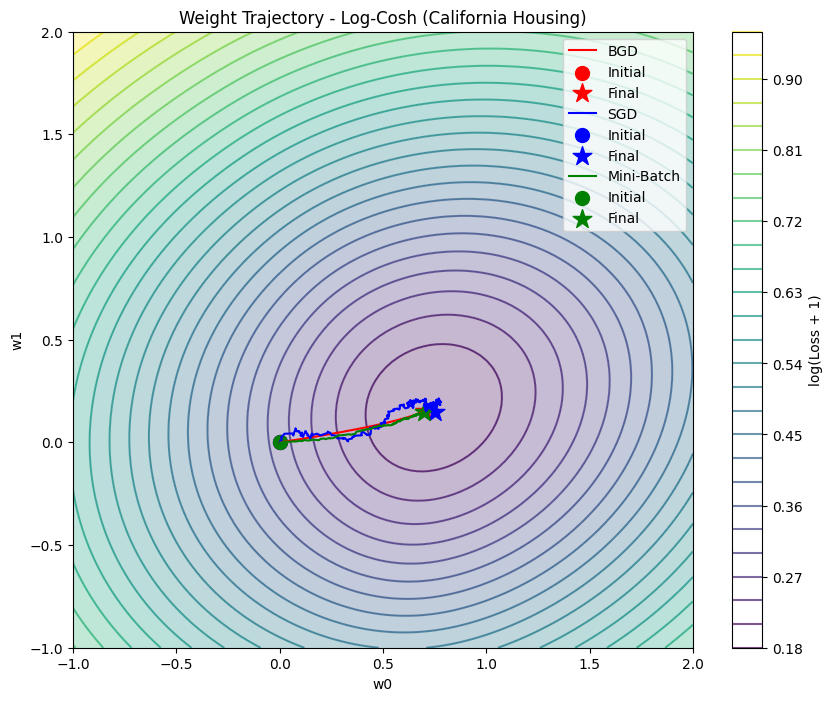

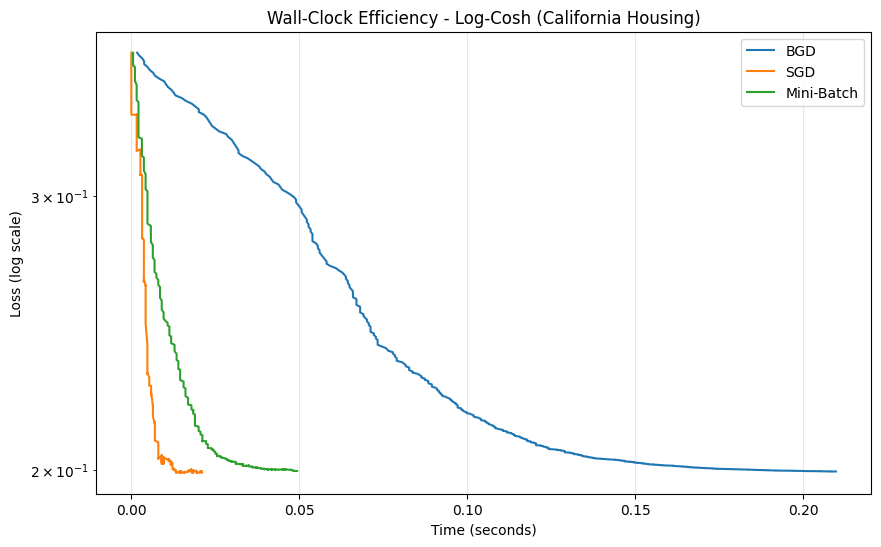

In [32]:

plot_convergence(results_logcosh_housing, 'Log-Cosh (California Housing)', 'housing_logcosh_convergence.png')
plot_trajectory(results_logcosh_housing, logcosh_loss, X_housing, y_housing, 'Log-Cosh (California Housing)', 'housing_logcosh_trajectory.png', w_range=(-1, 2))
plot_wall_clock(results_logcosh_housing, 'Log-Cosh (California Housing)', 'housing_logcosh_wall_clock.png') 

In [33]:

print("=" * 50)
print("COMPARISON: MSE vs Log-Cosh")
print("=" * 50)

print("\nFinal Weights Comparison:")
print(f"  MSE BGD:      {opt_bgd_mse.final_weights}")
print(f"  Log-Cosh BGD: {opt_bgd_lc.final_weights}")

print("\nFinal Loss Values (BGD):")
print(f"  MSE:      {results_mse_housing['BGD']['loss'][-1]:.4f}")
print(f"  Log-Cosh: {results_logcosh_housing['BGD']['loss'][-1]:.4f}")


def compute_errors(w, X, y):
    pred = X @ w
    errors = pred - y
    return {
        'MAE': np.mean(np.abs(errors)),
        'MSE': np.mean(errors**2),
        'Max Error': np.max(np.abs(errors))
    }

print("\nPrediction Errors (BGD):")
mse_errors = compute_errors(opt_bgd_mse.final_weights, X_housing, y_housing)
logcosh_errors = compute_errors(opt_bgd_lc.final_weights, X_housing, y_housing)

print(f"  MSE Loss Model:")
print(f"    MAE: {mse_errors['MAE']:.4f}, MSE: {mse_errors['MSE']:.4f}, Max: {mse_errors['Max Error']:.4f}")
print(f"  Log-Cosh Loss Model:")
print(f"    MAE: {logcosh_errors['MAE']:.4f}, MSE: {logcosh_errors['MSE']:.4f}, Max: {logcosh_errors['Max Error']:.4f}")

COMPARISON: MSE vs Log-Cosh

Final Weights Comparison:
  MSE BGD:      [0.70561634 0.16990464]
  Log-Cosh BGD: [0.70497838 0.15313099]

Final Loss Values (BGD):
  MSE:      0.4970
  Log-Cosh: 0.1996

Prediction Errors (BGD):
  MSE Loss Model:
    MAE: 0.5417, MSE: 0.4970, Max: 3.0819
  Log-Cosh Loss Model:
    MAE: 0.5421, MSE: 0.4973, Max: 3.0652
